# Normalization comparisson
In this notebook, I compare the different methods of normalization.
As a simple metric, I use the enrichment score at 99%.
This analysis is done on the efficientnetB0 pretrained output: `level3.csv`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycytominer import aggregate, annotate, normalize, feature_select, cyto_utils
from cytominer_eval import evaluate
from cytominer_eval.transform import metric_melt
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('/Users/mbornhol/git/neural-profiling/pre-trained/ResNet50v2/aggregated/aggregated_resnet_median.csv', low_memory=False)

In [3]:
meta = pd.read_csv('/Users/mbornhol/git/neural-profiling/pre-trained/data-prep/02_index_preperation/repurposing_info_external_moa_map_resolved.tsv', sep='\t')
meta = meta[['broad_sample', 'moa']]
meta.rename(columns = {'broad_sample' : 'Metadata_broad_sample', 'moa' : 'Metadata_moa'}, inplace=True)


In [4]:
p = 0.99

In [16]:
def hist(df, features):
    melt = metric_melt(df.sample(200),
            features=features,
            metadata_features=meta_features)
    #bins = np.arange(-0.005, 0.005, 0.001)
    plt.style.use({'figure.facecolor':'white'})
    plt.hist(melt.similarity_metric)

In [6]:
features = [f for f in df.columns if f.startswith('res')]
meta_features = [feat for feat in df.columns if feat not in features]

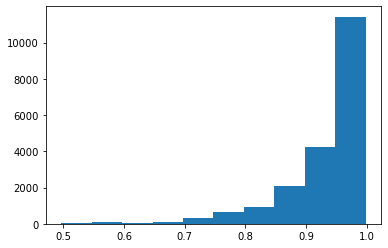

In [16]:
# plot the similarity of the wells. Expected output from a pretrained net.
hist(df,features)

Explained variation per principal component: [0.44954394 0.18522429 0.0831208 ]


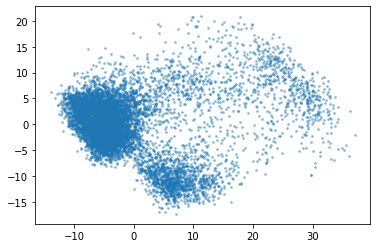

In [17]:
def pca_plot(df):
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[features].values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1]
    df['pca-three'] = pca_result[:,2]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    plt.style.use({'figure.facecolor':'white'})
    plt.scatter(df['pca-one'], df['pca-two'], s = 3, alpha= 0.4)
    plt.show()
pca_plot(df)

## Without normalization

In [18]:
con = aggregate(
    df,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])

In [19]:
res = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.996289,1.850777,5.674556e-14


## robustize

There doesn't seem to be a large difference between DMSO and all normalization.

In [20]:
rob_DMSO = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='robustize',
    output_file='none'
)
con = aggregate(
    rob_DMSO,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_rob_DMSO = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_rob_DMSO

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.998235,1.829675,1.967001e-13


In [21]:
rob_all = normalize(
    profiles=df,
    features=features,
    samples="all",
    method='robustize',
    output_file='none'
)
con = aggregate(
    rob_all,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_rob_all = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_rob_all

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.948421,2.573752,1.867257e-37


## standardize

In [23]:
stand_dmso = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='standardize',
    output_file='none'
)
con = aggregate(
    stand_dmso,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_stand_dmso = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_stand_dmso

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.860667,2.06159,7.268180e-20


## Mad robustize

In [14]:
mad_dmso = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='mad_robustize',
    output_file='none'
)
con = aggregate(
    mad_dmso,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_mad_dmso = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_mad_dmso

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.864618,3.637524,9.708554e-54


## feature select and spherize 

In [7]:
feature_select_ops = [
    "variance_threshold",
    "drop_outliers",
]
selected = feature_select(
    profiles=df,
    features=features,
    operation=feature_select_ops,
    freq_cut=0.01,
    unique_cut=0.1,
    outlier_cutoff=1000,
)
print(selected.shape)

(8733, 2624)


In [8]:
feats = [f for f in selected.columns if f.startswith('res')]
sphere_select = normalize(
    profiles=selected,
    features=feats,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)

In [ ]:
p_range = np.arange(0.995, 0.96, -0.005)
con = aggregate(
    sphere_select,
    strata=["Metadata_broad_sample"],
    features=feats
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_enr_selected_sphere = evaluate(
        profiles=con,
        features=feats,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_enr_selected_sphere

## Plot PCA

Explained variation per principal component: [0.59846961 0.24697166 0.14507021]
Explained variation per principal component: [0.72449874 0.09701673 0.03942418]
Explained variation per principal component: [0.76889235 0.154502   0.03087662]


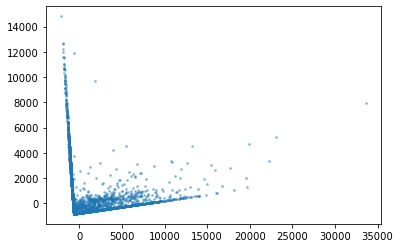

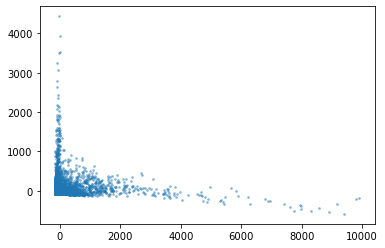

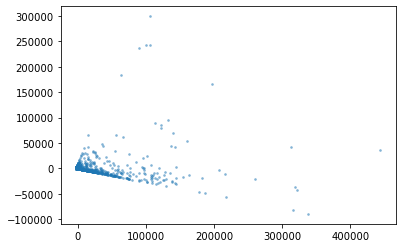

NameError: name 'mad_dmso' is not defined

In [24]:
pca_plot(rob_DMSO)
pca_plot(rob_all)
pca_plot(stand_dmso)
pca_plot(mad_dmso)

In [ ]:
pca_plot(sphere_select)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(sphere_select[features].values)
sphere_select['pca-one'] = pca_result[:,0]
sphere_select['pca-two'] = pca_result[:,1]
sphere_select['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere_select['pca-three'], sphere_select['pca-two'], s = 3, alpha= 0.4)
plt.show()

In [ ]:
def is_dmso(sample):
    if sample == 'DMSO':
        return 0
    else:
        return 1
sphere_select['color'] = sphere_select.Metadata_broad_sample.apply(is_dmso)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere_select['pca-one'], sphere_select['pca-two'], c = sphere_select['color'], marker= 'o', s = 2, alpha= 0.4, cmap = 'prism')
plt.show()

## Feature selection

In [29]:
feature_select_ops = [
    "variance_threshold",
]
select_var = feature_select(
    profiles=df,
    features=features,
    operation=feature_select_ops,
    freq_cut=0.01,
    unique_cut=0.1,
)
print(select_var.shape)

(8733, 2627)


Variance threshold with the standard cutoffs has no effect

In [31]:
feature_select_ops = [
    "drop_outliers",
]
select_other = feature_select(
    profiles=df,
    features=features,
    operation=feature_select_ops,
    outlier_cutoff=10000,
)

In [36]:
feats = [f for f in select_var.columns if f.startswith('res')]

sphere_select = normalize(
    profiles=select_var,
    features=feats,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)

In [39]:
p_range = np.arange(0.995, 0.96, -0.005)
con = aggregate(
    sphere_select,
    strata=["Metadata_broad_sample"],
    features=feats
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_select_other = evaluate(
        profiles=con,
        features=feats,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p_range
    )
res_select_other

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.411606,16.123392,0.0
1,0.990,0.322816,10.710581,0.0
2,0.985,0.270814,8.046930,0.0
3,0.980,0.235071,6.642723,0.0
4,0.975,0.207879,5.843032,0.0
5,0.970,0.187387,5.156616,0.0
6,0.965,0.170969,4.688170,0.0
7,0.960,0.157446,4.257467,0.0


In [40]:
# save to results

res_select_other.to_csv('../results/res_enrichment_spherized_selected.csv')

# best

In [18]:
feature_select_ops = [
    "variance_threshold",
    "drop_outliers",
]
selected = feature_select(
    profiles=df,
    features=features,
    operation=feature_select_ops,
    freq_cut=0.01,
    unique_cut=0.1,
    outlier_cutoff=1000,
)
print(selected.shape)

(8733, 2624)


In [19]:
feats = [f for f in selected.columns if f.startswith('res')]
sphere_select = normalize(
    profiles=selected,
    features=feats,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)

In [20]:
p_range = np.arange(0.995, 0.96, -0.005)
con = aggregate(
    sphere_select,
    strata=["Metadata_broad_sample"],
    features=feats
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_enr_selected_sphere = evaluate(
        profiles=con,
        features=feats,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p_range
    )
res_enr_selected_sphere

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.411606,16.123392,0.0
1,0.990,0.322816,10.710581,0.0
2,0.985,0.270814,8.046930,0.0
3,0.980,0.235071,6.642723,0.0
4,0.975,0.207879,5.843032,0.0
5,0.970,0.187387,5.156616,0.0
6,0.965,0.170969,4.688170,0.0
7,0.960,0.157446,4.257467,0.0


In [21]:
k_range = [5, 10, 15, 20, 25, 30, 40, 50]
con = con[con["Metadata_broad_sample"] != 'DMSO']
prc = evaluate(
    profiles=con,
    features=feats,
    meta_features=['Metadata_broad_sample', "Metadata_moa"],
    replicate_groups=["Metadata_moa"],
    operation="precision_recall",
    similarity_metric="pearson",
    precision_recall_k=k_range
)

In [33]:
top_moa = df.Metadata_moa.value_counts()[1:20].keys().tolist()
top_prc = prc[prc['Metadata_moa'].isin(top_moa)].reset_index(drop=True)
pr_av = []
for k in top_prc.k.unique():
    pr_av.append(top_prc.query("k==@k").mean().tolist())
res_prec_select_sphere = pd.DataFrame(pr_av, columns=["k","precision","recall"])
res_prec_select_sphere

,k,precision,recall
0,5.0,0.073684,0.002175
1,10.0,0.115789,0.006127
2,15.0,0.105263,0.008086
3,20.0,0.110526,0.010910
4,25.0,0.126316,0.015033
5,30.0,0.126316,0.016960
6,40.0,0.106579,0.019112
7,50.0,0.103158,0.022178


In [35]:
res_prec_select_sphere.to_csv('../results/res_prec_sphere_select.csv', index=False)
res_enr_selected_sphere.to_csv('../results/res_enr_sphere_select.csv', index=False)

In [22]:
# all MOAs
pr_av = []
for k in prc.k.unique():
    pr_av.append(prc.query("k==@k").mean().tolist())
res_prec_select_sphere_allMOA = pd.DataFrame(pr_av, columns=["k","precision","recall"])
res_prec_select_sphere_allMOA



,k,precision,recall
0,5.0,0.052137,0.030887
1,10.0,0.049145,0.038170
2,15.0,0.045014,0.045905
3,20.0,0.042308,0.050153
4,25.0,0.041538,0.054814
5,30.0,0.040456,0.069772
6,40.0,0.036432,0.083939
7,50.0,0.034017,0.091097
